## Import Libraries 

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings("ignore")

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

import optuna

from sklearn.metrics import accuracy_score, classification_report, plot_roc_curve
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


## Understanding the data

In [2]:
df = pd.read_csv('D/documents/insurance/insurance.csv')
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [4]:
le = LabelEncoder()

df['sex'] = le.fit_transform(df['sex'])
df['smoker'] = le.fit_transform(df['smoker'])
df['region'] = le.fit_transform(df['region'])

In [5]:
dict = {}
for i in list(df.columns):
    dict[i] = df[i].value_counts().shape[0]

pd.DataFrame(dict,index=["unique count"]).transpose()

,unique count
age,47
sex,2
bmi,548
children,6
smoker,2
region,4
charges,1337


## Visualization
Up untill this point i was going to treat it as a regression problem and have "Charges" as the target, so i decided to put some things in visual form to see if i was missing anything, and thats when something stood out to me, the huge discrepancy on the **'smoker'** plot.


<AxesSubplot:xlabel='region', ylabel='charges'>

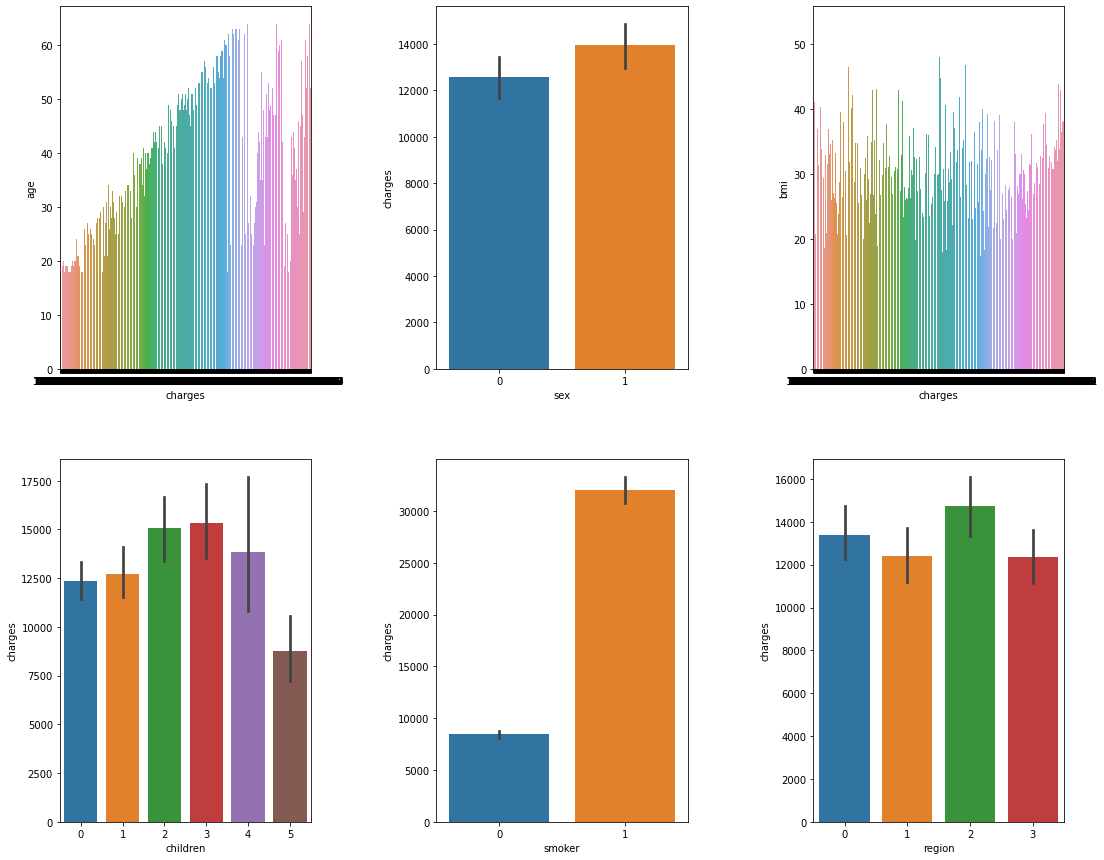

In [6]:
fig = plt.figure(figsize=(18,15))
gs = fig.add_gridspec(2,3)
gs.update(wspace=0.5, hspace=0.25)
ax0 = fig.add_subplot(gs[0,0])
ax1 = fig.add_subplot(gs[0,1])
ax2 = fig.add_subplot(gs[0,2])
ax3 = fig.add_subplot(gs[1,0])
ax4 = fig.add_subplot(gs[1,1])
ax5 = fig.add_subplot(gs[1,2])

sns.barplot(ax=ax0,data=df,x='charges',y = 'age')
sns.barplot(ax=ax1,data=df,x='sex',y = 'charges')
sns.barplot(ax=ax2,data=df,x='charges',y = 'bmi')
sns.barplot(ax=ax3,data=df,x='children',y = 'charges')
sns.barplot(ax=ax4,data=df,x='smoker',y = 'charges')
sns.barplot(ax=ax5,data=df,x='region',y = 'charges')

## Confirmation
The idea was that smoking was by far the feature with the highest relevance / correlation with medical charges, so i checked to make sure.


In [7]:
df.corr()

,age,sex,bmi,children,smoker,region,charges
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.002127,0.299008
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.004588,0.057292
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.157566,0.198341
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.016569,0.067998
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,-0.002181,0.787251
region,0.002127,0.004588,0.157566,0.016569,-0.002181,1.000000,-0.006208
charges,0.299008,0.057292,0.198341,0.067998,0.787251,-0.006208,1.000000


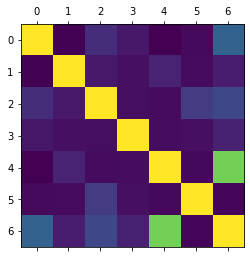

In [8]:
plt.matshow(df.corr())
plt.show()

In [9]:
corr = df.corr()
cmap = cmap=sns.diverging_palette(5, 250, as_cmap=True)
corr.style.background_gradient(cmap, axis=1)\
    .set_properties(**{'max-width': '80px', 'font-size': '10pt'})\
    .set_precision(2)

,age,sex,bmi,children,smoker,region,charges
age,1.00,-0.02,0.11,0.04,-0.03,0.00,0.30
sex,-0.02,1.00,0.05,0.02,0.08,0.00,0.06
bmi,0.11,0.05,1.00,0.01,0.00,0.16,0.20
children,0.04,0.02,0.01,1.00,0.01,0.02,0.07
smoker,-0.03,0.08,0.00,0.01,1.00,-0.00,0.79
region,0.00,0.00,0.16,0.02,-0.00,1.00,-0.01
charges,0.30,0.06,0.20,0.07,0.79,-0.01,1.00


In [10]:
from patsy import dmatrices
from statsmodels.stats.outliers_influence import variance_inflation_factor


y, X = dmatrices('charges ~ age+bmi+sex+children+smoker+region+charges', data=df, return_type='dataframe')

vif = pd.DataFrame()
vif['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
vif['variable'] = X.columns


vif

,VIF,variable
0,37.063405,Intercept
1,1.372866,age
2,1.153126,bmi
3,1.009006,sex
4,1.011617,children
5,3.536099,smoker
6,1.030143,region
7,4.011830,charges


## Change
After confirming the theory i decided to change it up, making it a Classification problem instead, and trying to see if i could predict if the person was a smoker or not instead of predicting charges.


In [11]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('smoker', axis = 1),
                                                   df['smoker'],
                                                   test_size = 0.25,
                                                   random_state=42)

## Models
Trying out a couple different models to see what performs best.


In [12]:
pipe1 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', SVC(random_state=42))
])

model_svm = pipe1.fit(x_train, y_train)

y_pred_svm = model_svm.predict(x_test)

In [13]:
pipe2 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', KNeighborsClassifier())
])

model_kn = pipe2.fit(x_train, y_train)

y_pred_kn = model_kn.predict(x_test)

In [14]:
pipe3 = Pipeline([
    ('scaler', StandardScaler()),
    ('model', LogisticRegression())
])

model_lr = pipe3.fit(x_train, y_train)

y_pred_lr = model_lr.predict(x_test)

In [15]:
model_rf = RandomForestClassifier(random_state=42).fit(x_train, y_train)

y_pred_rf = model_rf.predict(x_test)

In [16]:
model_gb = GradientBoostingClassifier(random_state=42).fit(x_train, y_train)

y_pred_gb = model_gb.predict(x_test)

In [17]:
model_dt = DecisionTreeClassifier(random_state=42).fit(x_train, y_train)

y_pred_dt = model_dt.predict(x_test)

In [18]:
print('Accuracy score SVM: {:.4f}' .format(accuracy_score(y_test, y_pred_svm)))
print('Accuracy score KN:  {:.4f}' .format(accuracy_score(y_test, y_pred_kn)))
print('Accuracy score LR:  {:.4f}' .format(accuracy_score(y_test, y_pred_lr)))
print('Accuracy score RF:  {:.4f}' .format(accuracy_score(y_test, y_pred_rf)))
print('Accuracy score GB:  {:.4f}' .format(accuracy_score(y_test, y_pred_gb)))
print('Accuracy score DT:  {:.4f}' .format(accuracy_score(y_test, y_pred_dt)))

Accuracy score SVM: 0.9642
Accuracy score KN:  0.9493
Accuracy score LR:  0.9612
Accuracy score RF:  0.9701
Accuracy score GB:  0.9701
Accuracy score DT:  0.9612


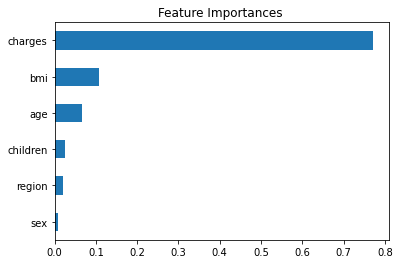

In [19]:
feat_importances = pd.Series(model_rf.feature_importances_, index = x_train.columns).sort_values(ascending = True)
feat_importances.plot(kind = 'barh')
plt.title('Feature Importances ')
plt.show()

## Hyperparameter tuning
The best performing models were RandomForest and GradientBoosting, so the goal now is to try to make them better with the use of Optuna

### RF Hyperparameter tuning

In [20]:
rfc = RandomForestClassifier(random_state=42)

n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
max_features = ['auto', 'sqrt', 'log2']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]

params_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [21]:
random_search = RandomizedSearchCV(estimator = rfc,  param_distributions = params_grid, verbose = 1, cv = 5, n_iter = 100, random_state = 42)

random_search.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt',
                                                         'log2'],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 400, 600, 800,
                                                         1000, 1200, 1400, 1600,
                                                         1800, 2000]},
                   random_state=42, verbose=1)

In [22]:
print(f'best: {random_search.best_params_}')

best: {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 1, 'max_features': 'log2', 'max_depth': 70, 'bootstrap': False}


In [23]:
rf_rs = RandomForestClassifier(n_estimators = 200, min_samples_split = 5, min_samples_leaf = 1, max_features = 'log2', max_depth = 70, bootstrap = False, random_state = 42)

model_rf_rs = rf_rs.fit(x_train, y_train)

y_pred_rf_rs = model_rf_rs.predict(x_test)

### GB Hyperparameter tuning

In [24]:
gbc = GradientBoostingClassifier(random_state = 42)
parameters = {
    "n_estimators":[5,50,250,500],
    "max_depth":[1,3,5,7,9],
    "learning_rate":[0.01,0.1,1,10,100]
}

In [25]:
random_search_gb = RandomizedSearchCV(estimator = gbc,  param_distributions = parameters, verbose = 1, cv = 5, n_iter = 100, random_state = 42)

random_search_gb.fit(x_train, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


RandomizedSearchCV(cv=5, estimator=GradientBoostingClassifier(random_state=42),
                   n_iter=100,
                   param_distributions={'learning_rate': [0.01, 0.1, 1, 10,
                                                          100],
                                        'max_depth': [1, 3, 5, 7, 9],
                                        'n_estimators': [5, 50, 250, 500]},
                   random_state=42, verbose=1)

In [26]:
print(f'best: {random_search_gb.best_params_}')

best: {'n_estimators': 250, 'max_depth': 5, 'learning_rate': 0.01}


In [27]:
gb_rs = GradientBoostingClassifier(n_estimators = 250, max_depth = 5, learning_rate = 0.01)

model_gb_rs = gb_rs.fit(x_train, y_train)

y_pred_gb_rs = model_gb_rs.predict(x_test)

## Results from Hyperparameter tuning
Best end result was RandomForest with the help of RandomizedSearchCV for better parameters.


In [28]:
print('Accuracy Score RF:                   {:.4f}' .format(accuracy_score(y_test, y_pred_rf)))
print('Accuracy Score RF + RandomSearchCV:  {:.4f}' .format(accuracy_score(y_test, y_pred_rf_rs)))
print('Accuracy score GB:                   {:.4f}' .format(accuracy_score(y_test, y_pred_gb)))
print('Accuracy score GB + RandomSearchCV:  {:.4f}' .format(accuracy_score(y_test, y_pred_gb_rs)))

Accuracy Score RF:                   0.9701
Accuracy Score RF + RandomSearchCV:  0.9791
Accuracy score GB:                   0.9701
Accuracy score GB + RandomSearchCV:  0.9701


## Evaluation
Using our best model, Hypertuned RandomForestClassifier.



In [29]:
print(classification_report(y_test, y_pred_rf_rs))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       267
           1       0.94      0.96      0.95        68

    accuracy                           0.98       335
   macro avg       0.97      0.97      0.97       335
weighted avg       0.98      0.98      0.98       335



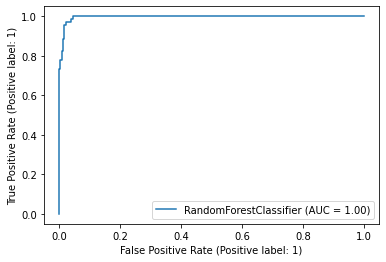

In [30]:
plot_roc_curve(model_rf_rs, x_test, y_test)

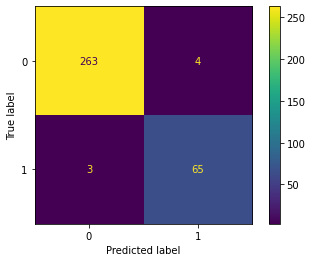

In [31]:
predictions = model_rf_rs.predict(x_test)
cm = confusion_matrix(y_test, y_pred_rf_rs, labels = model_rf_rs.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = model_rf_rs.classes_)
disp.plot()
plt.show()